In [87]:
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
matches_df = pd.read_csv('Matches_since_2k.csv', low_memory = False)

In [3]:
top_countries = ['Belgium', 'France', 'Brazil', 'England', 'Portugal', 'Spain', 'Italy', 'Argentina', 'Uruguay', 'Denmark', 'Mexico', 'Germany', 'Switzerland', 'Croatia', 'Colombia', 
                 'Netherlands', 'Wales', 'Sweden', 'Chile', 'United States', 'Poland', 'Senegal', 'Austria', 'Ukraine', 'Qatar', 'Serbia', 'Tunisia', 'Peru', 'Japan', 'Turkey', 'Venezuela', 
                 'Iran', 'Nigeria', 'Algeria', 'Morocco', 'Paraguay', 'Slovakia', 'Hungary', 'Russia', 'Korea Republic']
matches_df.drop(columns=['Unnamed: 0'], inplace = True)
matches_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2000-01-22,Ghana,Cameroon,1,1,African Cup of Nations,Accra,Ghana,False
1,2000-01-23,China PR,Philippines,8,0,AFC Asian Cup qualification,Hanoi,Vietnam,True
2,2000-01-23,Egypt,Zambia,2,0,African Cup of Nations,Kano,Nigeria,True
3,2000-01-23,Nigeria,Tunisia,4,2,African Cup of Nations,Lagos,Nigeria,False
4,2000-01-23,South Africa,Gabon,3,1,African Cup of Nations,Kumasi,Ghana,True


In [4]:
def euclidean(p1, p2):
    """ Euclidean distance measure """
    return sum([(x1-x2)**2 for x1,x2 in zip(p1,p2)]) ** 0.5

In [5]:
def normalize(df):
    result = df.copy()
    for feature_name in ['Average_Player_Score', 'Average_Player_Value', 'rank', 'Wins', 'Losses', 'Ties', 'Game_Count', 'win_percentage', 'lose_percentage']:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [6]:
country_df = pd.read_csv('DS3000PrepCode.csv')
country_df.drop(columns=['Unnamed: 0'], inplace = True)
country_df = normalize(country_df)
# Trying ot add qatar to df with normalized variables, need to check for all other countries too to make sure they work
country_df.loc[len(country_df.index)] = ['Qatar', .3, .2, .2829, .685, .537, .6667, .864, .4555, .3036]
country_df = country_df.drop(columns=['Wins', 'Losses'])
country_df.head()

,Country,Average_Player_Score,Average_Player_Value,rank,Ties,Game_Count,win_percentage,lose_percentage
0,Belgium,0.949153,0.695554,0.000000,0.298507,0.631579,0.869606,0.171190
1,France,0.993644,1.000000,0.004902,0.552239,0.705263,0.891364,0.031979
2,Brazil,1.000000,0.883195,0.009804,0.597015,0.794737,0.860540,0.066435
3,England,0.959746,0.874906,0.014706,0.507463,0.678947,0.902231,0.037499
4,Portugal,0.947034,0.698568,0.019608,0.597015,0.736842,0.866799,0.041276


In [7]:
def get_countries():
    while True:
        country1 = input('What do you want the first country to be? ')
        if country1 in top_countries:
            break
    while True:
        country2 = input('What do you want the second country to be? ')
        if country2 in top_countries:
            break
    return country1, country2

In [8]:
def top_neighbors(country1, k):
    countrylist = country_df['Country'].tolist()
    country1_stats = country_df.iloc[(countrylist.index(country1))][1:]
    countries_list = []
    for i in range(len(country_df)):
        country2_stats = country_df.iloc[i][1:].tolist()
        distance = euclidean(country1_stats, country2_stats)
        countries_list.append((distance, country_df.iloc[i][0]))
    countries_list = sorted(countries_list)
    return countries_list[:k]

In [9]:
def get_win_rate(country1, country2):
    # If the two countries are the same each would obviously have a 50% chance either way
    if country1 == country2:
        return .5, .5
    temp_df = matches_df[(matches_df['home_team'] == country1) | (matches_df['away_team'] == country1)]
    twocountries_df = temp_df[(temp_df['home_team'] == country2) | (temp_df['away_team'] == country2)]
    country1points = 0
    country2points = 0
    # If there are no matchups, we return .5 and .5 as we'll just assume it's even
    if twocountries_df.empty:
        return False, False
    for row in twocountries_df.iterrows():
        if row[1][1] == country1:
            if row[1][3] > row[1][4]:
                country1points += 1
            elif row[1][3] < row[1][4]:
                country2points += 1
            else:
                country1points += .5
                country2points += .5
        else:
            if row[1][3] > row[1][4]:
                country2points += 1
            elif row[1][3] < row[1][4]:
                country1points += 1
            else:
                country1points += .5
                country2points += .5
    # If countries have only played each other once, and the match is a draw, we don't consider it
    if country1points == .5 and country2points == .5:
        return False, False
    pointssum = country1points + country2points
    # Returning the average chance at victory
    return country1points/pointssum, country2points/pointssum

In [10]:
def get_odds(country1, country2):
    k = 25
    # Getting the top neighbors and their distance
    country1_scores = top_neighbors(country1, k)
    country2_scores = top_neighbors(country2, k)
    mostsimilar = []

    # Finding the overall most similar matchups
    for i in range(len(country1_scores)):
        for j in range(len(country2_scores)):
            firstcountry = country1_scores[i][1]
            secondcountry = country2_scores[j][1]
            countries = [country1_scores[i][1], country2_scores[j][1]]
            scoresum = country1_scores[i][0] + country2_scores[j][0]
            mostsimilar.append((scoresum, countries))
    mostsimilar = sorted(mostsimilar)[:k]
    # Making blank lists for the likelihood
    firstcountrylikelihood = []
    secondcountrylikelihood = []

    # Getting the chances of winning for each of the most similar matches and averaging
    for i in range(len(mostsimilar)):
        firstsimilar = mostsimilar[i][1][0]
        secondsimilar = mostsimilar[i][1][1]
        country1points, country2points = get_win_rate(firstsimilar, secondsimilar)
        if country1points != False:
            firstcountrylikelihood.append(country1points)
            secondcountrylikelihood.append(country2points)
    if len(firstcountrylikelihood) == 0 or len(secondcountrylikelihood) == 0:
        return .5, .5
    firstodds = round(sum(firstcountrylikelihood)/len(firstcountrylikelihood), 2)
    secondodds = round(sum(secondcountrylikelihood)/len(secondcountrylikelihood), 2)
    return firstodds, secondodds

In [39]:
def creategroups():
    # Randomly creates the groups
    groups = [[], [], [], [], [], [], [], []]
    top8 = top_countries[:8]
    second8 = top_countries[8:16]
    third8 = top_countries[16:24]
    lastgroup = top_countries[24:]
    last8 = ['Qatar']
    # Basically some random numbers to determine the last qualifying teams, the better the team the higher the chance of qualifying
    while len(last8) < 8:
        testnum = random.randint(1, 200)
        if testnum in range(101, 127) and 'Peru' not in last8:
            last8.append('Peru')
        elif testnum in range(127, 160) and 'Tunisia' not in last8:
            last8.append('Tunisia')
        elif testnum in range(160, 201) and 'Serbia' not in last8:
            last8.append('Serbia')
        elif testnum in range(0, 20) and 'Japan' not in last8:
            last8.append('Japan')
        elif testnum in range(20, 35) and 'Turkey' not in last8:
            last8.append('Turkey')
        elif testnum in range(35, 49) and 'Venezeula' not in last8:
            last8.append('Venezuela')
        elif testnum in range(49, 60) and 'Iran' not in last8:
            last8.append('Iran')
        elif testnum in range(60, 70) and 'Nigeria' not in last8:
            last8.append('Nigeria')
        elif testnum in range(70, 78) and 'Algeria' not in last8:
            last8.append('Algeria')
        elif testnum in range(78, 83) and 'Morocco' not in last8:
            last8.append('Morocco')
        elif testnum in range(83, 88) and 'Paraguay' not in last8:
            last8.append('Paraguay')
        elif testnum in range(88, 92) and 'Hungary' not in last8:
            last8.append('Hungary')
        elif testnum in range(93, 97) and 'Russia' not in last8:
            last8.append('Russia')
        elif testnum in range(97, 101) and 'Korea Republic' not in last8:
            last8.append('Korea Republic')
    # Randomly forming the groups
    for lst in [top8, second8, third8, last8]:
        inlist = len(groups[0])
        for country in lst:
            while True:
                num = random.randint(0, 7)
                if inlist == len(groups[num]):
                    groups[num].append(country)
                    break
    return groups

In [40]:
def groupstage(groups):
    # Performs the group stage matches and creates the bracket
    leftside = []
    rightside = []
    counter = 1
    for group in groups:
        grouppoints = [[0, group[0]], [0, group[1]], [0, group[2]], [0, group[3]]]
        allmatches = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
        for match in allmatches:
            team1, team2 = match[0], match[1]
            team1odds, team2odds = (get_odds(group[team1], group[team2]))
            # Deciding the result of the game based on the odds
            decider = random.random()
            if decider <= team1odds:
                grouppoints[team1][0] += 1
            else:
                grouppoints[team2][0] += 1
                
        # Going through the lists to get the top two teams- we can't use sorted because it would go by alphabetically as a fallback
        # In the event of a tie in points, we're just giving the win to the higher ranked team
        toptwo = []
        scores = [subgroup[0] for subgroup in grouppoints]
        ordered = sorted(scores, reverse = True)
        if ordered == [3, 2, 1, 0] or ordered == [3, 1, 1, 1]:
            while len(toptwo) < 2:
                for subgroup in grouppoints:
                    if subgroup[0] == 3:
                        toptwo.append(subgroup[1])
                for subgroup in grouppoints:
                    if subgroup[0] == 2:
                        toptwo.append(subgroup[1])
                if len(toptwo) == 2:
                    break
                for subgroup in grouppoints:
                    if subgroup[0] == 1:
                        toptwo.append(subgroup[1])
                        break
        elif ordered == [2, 2, 1, 1] or ordered == [2, 2, 2, 0]:
            while len(toptwo) < 2:
                for subgroup in grouppoints:
                    if len(toptwo) == 2:
                        break
                    if subgroup[0] == 2:
                        toptwo.append(subgroup[1])
        
        if counter % 2 == 1:
            leftside.append(toptwo[0])
            rightside.append(toptwo[1])
        else:
            leftside.append(toptwo[1])
            rightside.append(toptwo[0])
        # use counter to determine if we should put winners on left or winners on right, it should go back and forth
        counter += 1
    return (leftside, rightside)

In [41]:
def midrounds(leftside, rightside):
    # Takes leftside and rightside of bracket, runs all the matches in it and gives the winners in a new leftside and rightside
    nextleft = []
    nextright = []
    for i in range(0, len(leftside), 2):
        team1odds, team2odds = (get_odds(leftside[i], leftside[(i+1)]))
        # Deciding the result of the game based on the odds
        decider = random.random()
        if decider <= team1odds:
            nextleft.append(leftside[i])
        else:
            nextleft.append(leftside[(i + 1)])
            
        team1odds, team2odds = (get_odds(rightside[i], rightside[(i+1)]))
        # Deciding the result of the game based on the odds
        decider = random.random()
        if decider <= team1odds:
            nextright.append(rightside[i])
        else:
            nextright.append(rightside[(i + 1)])
    return (nextleft, nextright)

In [62]:
def runtournament(n):
    # N is the number of tournaments to run
    tournamentcounter = 1
    winnersdict = {}
    secondplacedict = {}
    thirdplacedict = {}
    fourthplacedict = {}
    
    while tournamentcounter <= n:
        # Create groups, groups is returned as a nested list with each group as a list
        groups = creategroups()
        # print(groups) # uncomment this if you want to be able to see groups
        # Runs the groupstage and creates the bracket. Teams next to each other are the ones playing each other. Leftside is the left side of the bracket, rightside is the right side.
        # This is done the same way that FIFA does it from the group states (1st in A plays 2nd in B, 1st in C plays 2nd in D, etc on left 1st in B plays 2nd in A, etc on right)
        leftside, rightside = groupstage(groups)
        # print(leftside, rightside) # uncomment this if you want to be able to see initial bracket
        while len(leftside) > 1:
            # Runs this midrounds function to serve as the middle rounds of the tournaments
            leftside, rightside = midrounds(leftside, rightside)
            if len(leftside) == 2:
                final_four = [leftside[0], leftside[1], rightside[0], rightside[1]]
            # print(leftside, rightside) # uncomment this if you want to be able to see round progression

            
        # Third place match
        third_place_teams = []
        for team in final_four:
            if team != leftside[0] and team != rightside[0]:
                third_place_teams.append(team)
        # print(third_place_teams) # uncomment this if you want to be able to see the two teams playing in the third place match
        team1odds, team2odds = get_odds(final_four[0], final_four[1])
        decider = random.random()
        if decider <= team1odds:
            winner = third_place_teams[0]
            second = third_place_teams[1]
        else:
            winner = third_place_teams[0]
            second = third_place_teams[1]
        if winner in thirdplacedict:
            thirdplacedict[winner] += 1
        else:
            thirdplacedict[winner] = 1
        if second in fourthplacedict:
            fourthplacedict[second] += 1
        else:
            fourthplacedict[second] = 1
        # print(winner, second) # uncomment this if you want to be able to see the third and fourth place teams in order
            
        # FINALS
        # print(leftside[0], rightside[0]) # uncomment this if you want to be able to see the two teams in the finals
        team1odds, team2odds = get_odds(leftside[0], rightside[0])
        decider = random.random()
        if decider <= team1odds:
            winner = leftside[0]
            second = rightside[0]
        else:
            winner = rightside[0]
            second = leftside[0]
        if winner in winnersdict:
            winnersdict[winner] += 1
        else:
            winnersdict[winner] = 1
        if second in secondplacedict:
            secondplacedict[second] += 1
        else:
            secondplacedict[second] = 1
        print('The winner of tournament number', tournamentcounter, 'is', winner, '!')
        # print(winner, second) # uncomment this if you want to be able to see the first and second place teams in order
        
        tournamentcounter += 1
    return (winnersdict, secondplacedict, thirdplacedict, fourthplacedict)

In [63]:
winnersdict, secondplacedict, thirdplacedict, fourthplacedict = runtournament(1000)

The winner of tournament number 1 is France !
The winner of tournament number 2 is Argentina !
The winner of tournament number 3 is Italy !
The winner of tournament number 4 is Belgium !
The winner of tournament number 5 is France !
The winner of tournament number 6 is Belgium !
The winner of tournament number 7 is Italy !
The winner of tournament number 8 is Brazil !
The winner of tournament number 9 is Belgium !
The winner of tournament number 10 is Germany !
The winner of tournament number 11 is Switzerland !
The winner of tournament number 12 is Spain !
The winner of tournament number 13 is Spain !
The winner of tournament number 14 is Argentina !
The winner of tournament number 15 is England !
The winner of tournament number 16 is Belgium !
The winner of tournament number 17 is Brazil !
The winner of tournament number 18 is England !
The winner of tournament number 19 is Italy !
The winner of tournament number 20 is Poland !
The winner of tournament number 21 is Croatia !
The winn

In [64]:
print(winnersdict)
print(secondplacedict)
print(thirdplacedict)
print(fourthplacedict)

{'France': 136, 'Argentina': 82, 'Italy': 80, 'Belgium': 65, 'Brazil': 128, 'Germany': 80, 'Switzerland': 13, 'Spain': 81, 'England': 81, 'Poland': 3, 'Croatia': 20, 'Colombia': 10, 'Chile': 2, 'Portugal': 80, 'Netherlands': 72, 'Ukraine': 6, 'Uruguay': 13, 'Denmark': 11, 'Mexico': 15, 'Wales': 1, 'Algeria': 2, 'Paraguay': 3, 'United States': 7, 'Senegal': 5, 'Sweden': 1, 'Serbia': 1, 'Turkey': 1, 'Japan': 1}
{'Portugal': 72, 'Germany': 83, 'Uruguay': 39, 'England': 84, 'Spain': 82, 'France': 81, 'Argentina': 69, 'Brazil': 96, 'Morocco': 2, 'Netherlands': 72, 'Italy': 68, 'Mexico': 23, 'United States': 1, 'Denmark': 33, 'Nigeria': 2, 'Serbia': 4, 'Croatia': 30, 'Switzerland': 18, 'Colombia': 19, 'Austria': 2, 'Sweden': 6, 'Belgium': 62, 'Chile': 9, 'Turkey': 4, 'Tunisia': 2, 'Poland': 5, 'Qatar': 3, 'Ukraine': 10, 'Japan': 2, 'Iran': 1, 'Senegal': 11, 'Wales': 3, 'Russia': 1, 'Peru': 1}
{'Italy': 72, 'Brazil': 76, 'England': 96, 'Poland': 4, 'Netherlands': 74, 'Iran': 4, 'France': 76, 

In [84]:
def sorteddictionary(dictionary):
    nested = []
    for key, value in dictionary.items():
        nested.append((value, key))
    nested = sorted(nested, reverse = True)
    newdictionary = {}
    for value, key in nested:
         newdictionary[key] = value
    return newdictionary

In [86]:
sortedwinners = sorteddictionary(winnersdict)
sortedsecond = sorteddictionary(secondplacedict)
sortedthird = sorteddictionary(thirdplacedict)
sortedfourth = sorteddictionary(fourthplacedict)

print(sortedwinners)
print(sortedsecond)
print(sortedthird)
print(sortedfourth)

{'France': 136, 'Brazil': 128, 'Argentina': 82, 'Spain': 81, 'England': 81, 'Portugal': 80, 'Italy': 80, 'Germany': 80, 'Netherlands': 72, 'Belgium': 65, 'Croatia': 20, 'Mexico': 15, 'Uruguay': 13, 'Switzerland': 13, 'Denmark': 11, 'Colombia': 10, 'United States': 7, 'Ukraine': 6, 'Senegal': 5, 'Poland': 3, 'Paraguay': 3, 'Chile': 2, 'Algeria': 2, 'Wales': 1, 'Turkey': 1, 'Sweden': 1, 'Serbia': 1, 'Japan': 1}
{'Brazil': 96, 'England': 84, 'Germany': 83, 'Spain': 82, 'France': 81, 'Portugal': 72, 'Netherlands': 72, 'Argentina': 69, 'Italy': 68, 'Belgium': 62, 'Uruguay': 39, 'Denmark': 33, 'Croatia': 30, 'Mexico': 23, 'Colombia': 19, 'Switzerland': 18, 'Senegal': 11, 'Ukraine': 10, 'Chile': 9, 'Sweden': 6, 'Poland': 5, 'Turkey': 4, 'Serbia': 4, 'Wales': 3, 'Qatar': 3, 'Tunisia': 2, 'Nigeria': 2, 'Morocco': 2, 'Japan': 2, 'Austria': 2, 'United States': 1, 'Russia': 1, 'Peru': 1, 'Iran': 1}
{'Spain': 101, 'England': 96, 'Portugal': 77, 'Belgium': 77, 'France': 76, 'Brazil': 76, 'Netherland

In [141]:
sortedoverall = dict(sortedwinners)
for key, value in sortedoverall.items():
    numlist = [value]
    sortedoverall[key] = numlist 
for key, value in sortedsecond.items():
    if key in sortedoverall:
        sortedoverall[key].append(value)
    else:
        sortedoverall[key] = [0, value]
for key, value in sortedoverall.items():
    if len(sortedoverall[key]) != 2:
        sortedoverall[key].append(0)
for key, value in sortedthird.items():
    if key in sortedoverall:
        sortedoverall[key].append(value)
    else:
        sortedoverall[key] = [0, 0, value]
for key, value in sortedoverall.items():
    if len(sortedoverall[key]) != 3:
        sortedoverall[key].append(0)
for key, value in sortedfourth.items():
    if key in sortedoverall:
        sortedoverall[key].append(value)
    else:
        sortedoverall[key] = [0, 0, value]
for key, value in sortedoverall.items():
    if len(sortedoverall[key]) != 4:
        sortedoverall[key].append(0)
valueslist = list(sortedoverall.values())
for i in range(len(valueslist)):
    for j in range(len(valueslist[i])):
        valueslist[i][j] = valueslist[i][j] / 10
    

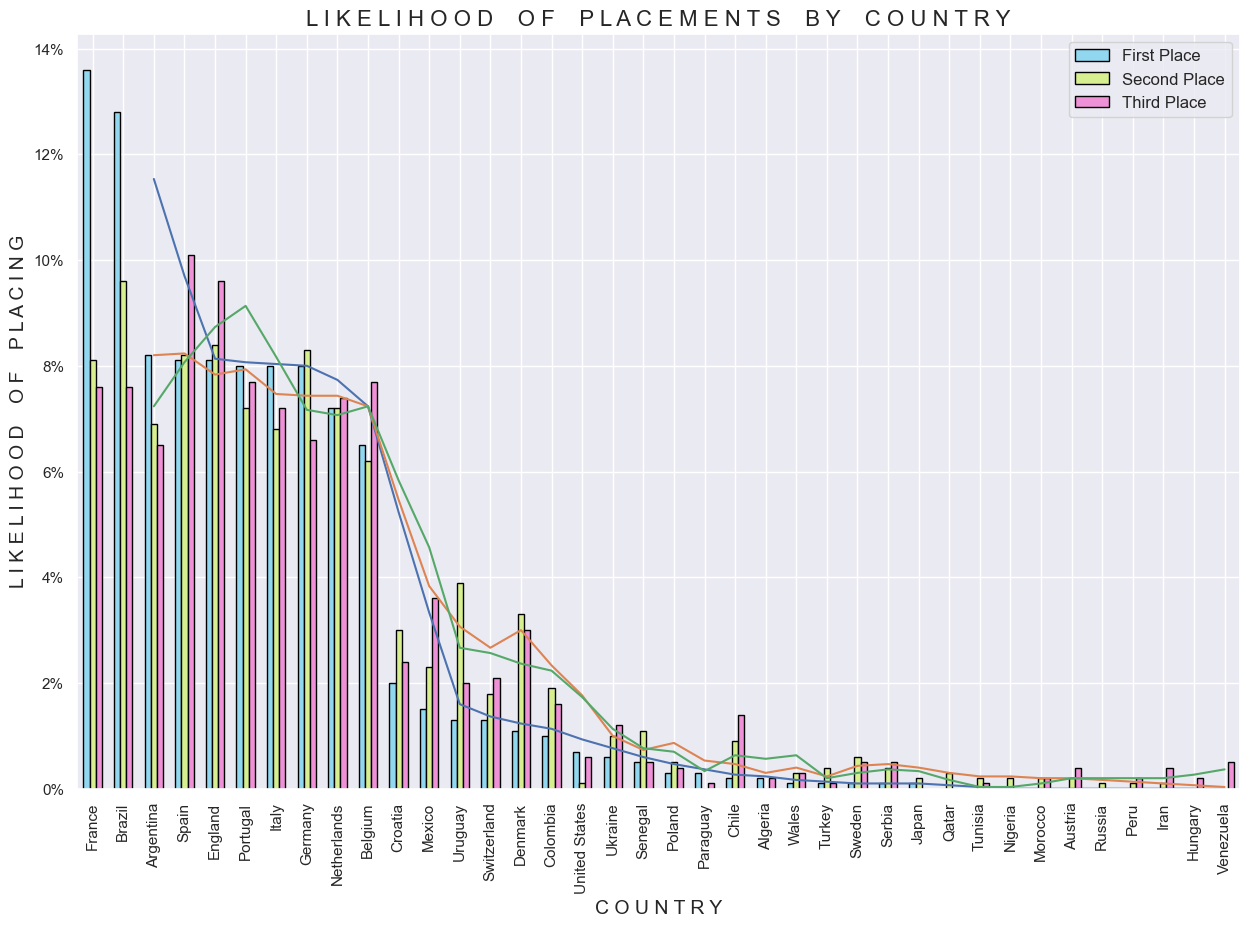

In [226]:
sns.set_theme()
plt.figure(figsize=(15, 10), dpi=100)

X_axis = np.arange(len(sortedoverall.keys()))
firsty = [i[0] for i in valueslist]
secondy = [i[1] for i in valueslist]
thirdy = [i[2] for i in valueslist]

X_axis = np.arange(len(sortedoverall.keys()))
plt.bar(X_axis - .2, firsty, .2, color = '#91D7EF', edgecolor = 'Black', label = 'First Place')
plt.bar(X_axis, secondy, .2, color = '#D7EF91', edgecolor = 'Black', label = 'Second Place')
plt.bar(X_axis + .2, thirdy, .2, color = '#EF91D7', edgecolor = 'Black', label = 'Third Place')


firstyseries = pd.Series(firsty)
secondyseries = pd.Series(secondy)
thirdyseries = pd.Series(thirdy)

firstyseries = firstyseries.rolling(3).mean()
secondyseries = secondyseries.rolling(3).mean()
thirdyseries = thirdyseries.rolling(3).mean()

plt.plot(X_axis, firstyseries)
plt.plot(X_axis, secondyseries)
plt.plot(X_axis, thirdyseries)



plt.xticks(X_axis, sortedoverall.keys(), rotation = 90)
plt.xlim(-.5, 37.5)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14], ['0%', '2%', '4%', '6%', '8%', '10%', '12%', '14%'])
plt.xlabel('C O U N T R Y', fontsize = 14)
plt.ylabel('L I K E L I H O O D    O F    P L A C I N G', fontsize = 14)
plt.title('L I K E L I H O O D    O F    P L A C E M E N T S    B Y    C O U N T R Y', fontsize = 16)
plt.legend(prop = {'size': 12})
plt.savefig("DS3000ProjectFig.png") # save as png
plt.show()
